In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from scipy.signal import hamming
from srmrpy.hilbert import hilbert
from srmrpy.modulation_filters import *
from gammatone.fftweight import fft_gtgram
from gammatone.filters import centre_freqs, make_erb_filters, erb_filterbank
from srmrpy.segmentaxis import segment_axis
from scipy.io.wavfile import read as readwav
import soundfile as sf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

/home/sspowar/cslab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_PATH = '/home/sspowar/scratch/archive/LA/LA'

In [3]:
# TRAIN

train_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt',
                       sep=" ", header=None)
train_df.columns =['speaker_id','filename','system_id','type','class_name']
# train_df.drop(columns=['null'],inplace=True)
train_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_train/flac/'+train_df.filename+'.flac'
train_df['target'] = (train_df.class_name=='spoof').astype('int32') # set labels 1 for fake and 0 for real
# if DEBUG:
#     train_df = train_df.groupby(['target']).sample(2500).reset_index(drop=True)
print(f'Train Samples: {len(train_df)}')

Train Samples: 25380


In [4]:
train_df.head()

,speaker_id,filename,system_id,type,class_name,filepath,target
0,LA_0079,LA_T_1138215,-,-,bonafide,/home/sspowar/scratch/archive/LA/LA/ASVspoof20...,0
1,LA_0079,LA_T_1271820,-,-,bonafide,/home/sspowar/scratch/archive/LA/LA/ASVspoof20...,0
2,LA_0079,LA_T_1272637,-,-,bonafide,/home/sspowar/scratch/archive/LA/LA/ASVspoof20...,0
3,LA_0079,LA_T_1276960,-,-,bonafide,/home/sspowar/scratch/archive/LA/LA/ASVspoof20...,0
4,LA_0079,LA_T_1341447,-,-,bonafide,/home/sspowar/scratch/archive/LA/LA/ASVspoof20...,0


In [46]:
def calc_erbs(low_freq, fs, n_filters):
    ear_q = 9.26449 # Glasberg and Moore Parameters
    min_bw = 24.7
    order = 1

    erbs = ((centre_freqs(fs, n_filters, low_freq)/ear_q)**order + min_bw**order)**(1/order)
    return erbs

def calc_cutoffs(cfs, fs, q):
    # Calculates cutoff frequencies (3 dB) for 2nd order bandpass
    w0 = 2*np.pi*cfs/fs
    B0 = np.tan(w0/2)/q
    L = cfs - (B0 * fs / (2*np.pi))
    R = cfs + (B0 * fs / (2*np.pi))
    return L, R

def normalize_energy(energy, drange=30.0):
    peak_energy = np.max(np.mean(energy, axis=0))
    min_energy = peak_energy*10.0**(-drange/10.0)
    energy[energy < min_energy] = min_energy
    energy[energy > peak_energy] = peak_energy
    return energy

def srmr(x, fs, n_cochlear_filters=23, low_freq=125, min_cf=4, max_cf=128, fast=True, norm=False):
    wLengthS = .256
    wIncS = .064
    # Computing gammatone envelopes
    if fast:
        mfs = 400.0
        gt_env = fft_gtgram(x, fs, 0.010, 0.0025, n_cochlear_filters, low_freq)
    else:
        cfs = centre_freqs(fs, n_cochlear_filters, low_freq)
        fcoefs = make_erb_filters(fs, cfs)
        gt_env = np.abs(hilbert(erb_filterbank(x, fcoefs)))
        mfs = fs

    wLength = int(np.ceil(wLengthS*mfs))
    wInc = int(np.ceil(wIncS*mfs))

    # Computing modulation filterbank with Q = 2 and 8 channels
    mod_filter_cfs = compute_modulation_cfs(min_cf, max_cf, 8)
    MF = modulation_filterbank(mod_filter_cfs, mfs, 2)

    n_frames = int(1 + (gt_env.shape[1] - wLength)//wInc)
    w = hamming(wLength+1)[:-1] # window is periodic, not symmetric

    energy = np.zeros((n_cochlear_filters, 8, n_frames))
    for i, ac_ch in enumerate(gt_env):
        mod_out = modfilt(MF, ac_ch)
        for j, mod_ch in enumerate(mod_out):
            mod_out_frame = segment_axis(mod_ch, wLength, overlap=wLength-wInc, end='pad')
            energy[i,j,:] = np.sum((w*mod_out_frame[:n_frames])**2, axis=1)

    if norm:
        energy = normalize_energy(energy)

    erbs = np.flipud(calc_erbs(low_freq, fs, n_cochlear_filters))

    avg_energy = np.mean(energy, axis=2)
    total_energy = np.sum(avg_energy)

    AC_energy = np.sum(avg_energy, axis=1)
    AC_perc = AC_energy*100/total_energy

    AC_perc_cumsum=np.cumsum(np.flipud(AC_perc))
    K90perc_idx = np.where(AC_perc_cumsum>90)[0][0]

    BW = erbs[K90perc_idx]

    cutoffs = calc_cutoffs(mod_filter_cfs, fs, 2)[0]

    if (BW > cutoffs[4]) and (BW < cutoffs[5]):
        Kstar=5
    elif (BW > cutoffs[5]) and (BW < cutoffs[6]):
        Kstar=6
    elif (BW > cutoffs[6]) and (BW < cutoffs[7]):
        Kstar=7
    elif (BW > cutoffs[7]):
        Kstar=8

    return np.sum(avg_energy[:, :4])/np.sum(avg_energy[:, 4:Kstar]), energy


def read_audio_file(filename, max_length=64600):
    # Use soundfile to read the .flac audio file
    audio_data, fs = sf.read(filename, always_2d=True, dtype='float32')
    # Normalize the audio data to the range [-1, 1]
    audio_data /= np.max(np.abs(audio_data))

    # Pad or truncate audio data to the desired max_length
    if len(audio_data) < max_length:
        padding = max_length - len(audio_data)
        audio_data = np.pad(audio_data, ((0, padding), (0, 0)), mode='constant')
    elif len(audio_data) > max_length:
        audio_data = audio_data[:max_length, :]
    return fs, audio_data

def process_file(f, n_cochlear_filters=23, low_freq=125, min_cf=4, max_cf=128, fast=True, norm=True):
    fs, s = read_audio_file(f)  # Use read_audio_file to handle .flac files
    if len(s.shape) > 1:
        s = s[:, 0]
    r, energy = srmr(s, fs, n_cochlear_filters=n_cochlear_filters,
                     min_cf=min_cf,
                     max_cf=max_cf,
                     fast=fast,
                     norm=norm)
    return energy, r


In [44]:
class SRMRDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        filepath = row['filepath']
        target = row['target']

        # Read the audio file and calculate SRMR
        energy, r = process_file(filepath)
        
        # Convert NumPy array to PyTorch tensor
        energy = torch.tensor(energy, dtype=torch.double)
        return energy, target

In [45]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

def calculate_eer(y_true, y_scores):
    fpr, fnr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    eer = fpr[np.nanargmin(np.abs(fpr - (1 - fnr)))]
    return eer


In [43]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    y_true = []
    y_scores = []

    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}", leave=False)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        predicted_labels = (output > 0.5).float()  # Assuming 0.5 threshold for binary classification
        total_correct += (predicted_labels == target).sum().item()
        total_samples += target.size(0)

        # Store true labels and predicted scores for EER calculation
        y_true.extend(target.cpu().numpy())
        y_scores.extend(output.cpu().detach().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    eer = calculate_eer(np.array(y_true), np.array(y_scores))
    return avg_loss, accuracy, eer

In [47]:
class CRNN_Model(nn.Module):
    def __init__(self, num_class:int, msr_size:tuple, rnn_hidden_size:int, dropout:float, tem_fac:list):
        super(CRNN_Model, self).__init__()
        self.num_class = num_class
        self.rnn_hidden_size = rnn_hidden_size
        self.dp = nn.Dropout(p=dropout)
        self.num_freq = msr_size[0]
        self.num_mod = msr_size[1]
        self.relu = nn.ReLU(inplace=True)
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.tem_fac = tem_fac
        
        self.cnn1 = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.BatchNorm3d(16),
            nn.MaxPool3d((self.tem_fac[0], 1, 1)),
            self.relu
        )
        
        self.cnn2 = nn.Sequential(
            nn.Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.BatchNorm3d(16),
            nn.MaxPool3d((self.tem_fac[1], 1, 1)),
            self.relu
        )
        
        self.cnn3 = nn.Sequential(
            nn.Conv3d(16, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.BatchNorm3d(4),
            nn.MaxPool3d((self.tem_fac[2], 1, 1)),
            self.relu
        )
        
        
        self.downsample = nn.MaxPool3d((2,2,2))
        
        self.CNNblock = nn.Sequential(
            self.cnn1,
            self.cnn2,
            self.cnn3
            )
        
        # self.Att = CBAM_Att(channel=4)
        
        self.fc1 = nn.Sequential(
            nn.Linear(20416, 128),
            nn.BatchNorm1d(128),
            self.relu,
            self.dp
            )
        
        # RNN
        self.rnn1 = nn.GRU(input_size=128, 
                            hidden_size=self.rnn_hidden_size,
                            num_layers=3,
                            bidirectional=True, 
                            batch_first=True)
        
        self.layer_norm = nn.LayerNorm([2*self.rnn_hidden_size,int(150/np.product(self.tem_fac))])
        self.maxpool = nn.MaxPool1d(int(150/np.product(self.tem_fac)))
        
        self.fc2 = nn.Linear(self.rnn_hidden_size*2, 1)
        
        self.initialize_weights()
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
    
    def forward(self, x):
        # Apply the CNN layers
        # print(x.shape)
        x = x.unsqueeze(1) 
        # print(x.shape)
        ot = self.CNNblock(x)
        # Flatten ot to have shape (batch_size, -1)
        ot = ot.view(ot.size(0), -1)

        # print(ot.shape)
        # Pass through the first fully connected layer
        ot = self.fc1(ot)
        # print(ot.shape)   
        # After the RNN layer, ot will have shape (batch_size, time_steps, rnn_hidden_size * 2)
        ot, _ = self.rnn1(ot)
        # print("RNN", ot.shape)
        
        ot = self.fc2(ot).squeeze(1).float()
        ot = torch.sigmoid(ot)
        # print("After FC2", ot.shape, ot)
        
        return ot

In [48]:
train_dataset = SRMRDataset(train_df[:5000])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [15]:
model = CRNN_Model(num_class=2, msr_size=(23, 8), rnn_hidden_size=128, dropout=0.7, tem_fac=[1, 2, 1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.double()
model.to(device)

# Train the model for a few epochs
num_epochs = 2
for epoch in range(1, num_epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Save the model after each epoch
    torch.save(model.state_dict(), f"crnn_model_epoch_{epoch}.pt")

    # Calculate EER using the ROC curve
    all_targets = []
    all_scores = []
    model.eval()
    with torch.no_grad():
        for data, target in tqdm(train_loader, desc="Calculating EER", leave=False):
            data, target = data.to(device), target.to(device)
            output = model(data).cpu().numpy()
            all_scores.extend(output)
            all_targets.extend(target.cpu().numpy())

    fpr, fnr, thresholds = roc_curve(all_targets, all_scores, pos_label=1)
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    print(f"Epoch {epoch}, Equal Error Rate (EER): {eer:.4f}")

Epoch 1:   0%|                                             | 0/313 [00:00<?, ?it/s]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.3916, 0.3902, 0.3758, 0.3621, 0.3549, 0.3676, 0.3811, 0.3910, 0.4057,
        0.4185, 0.4174, 0.4542, 0.4680, 0.4898, 0.4990, 0.5049],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   0%|                                   | 1/313 [00:26<2:15:49, 26.12s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.3276, 0.2986, 0.2452, 0.2247, 0.2040, 0.1830, 0.1656, 0.1416, 0.1126,
        0.1154, 0.1440, 0.1738, 0.2307, 0.2527, 0.2791, 0.3461],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   1%|▏                                  | 2/313 [00:35<1:23:57, 16.20s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.3123, 0.2836, 0.2669, 0.2291, 0.1936, 0.1761, 0.1526, 0.1398, 0.1303,
        0.1198, 0.1313, 0.1538, 0.1516, 0.1454, 0.1709, 0.2051],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   1%|▎                                  | 3/313 [00:47<1:13:27, 14.22s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.3804, 0.2793, 0.2306, 0.1850, 0.1987, 0.2497, 0.2471, 0.2629, 0.2444,
        0.1983, 0.1714, 0.1620, 0.1841, 0.1864, 0.2256, 0.2253],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   1%|▍                                  | 4/313 [00:59<1:09:06, 13.42s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.7251, 0.7492, 0.7564, 0.6892, 0.5378, 0.4197, 0.3983, 0.3778, 0.2687,
        0.2383, 0.2074, 0.2024, 0.2129, 0.2437, 0.2465, 0.3183],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   2%|▌                                  | 5/313 [01:12<1:08:50, 13.41s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.4369, 0.4347, 0.5220, 0.4818, 0.4520, 0.4904, 0.6345, 0.7672, 0.8334,
        0.8360, 0.7918, 0.6428, 0.4442, 0.4086, 0.3660, 0.3408],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   2%|▋                                  | 6/313 [01:21<1:01:04, 11.94s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.6181, 0.5788, 0.4064, 0.2866, 0.2831, 0.4393, 0.5145, 0.5609, 0.5431,
        0.5205, 0.5252, 0.5083, 0.3260, 0.2167, 0.1819, 0.2581],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   2%|▊                                    | 7/313 [01:30<55:26, 10.87s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.6551, 0.6678, 0.6823, 0.7771, 0.8666, 0.8700, 0.6838, 0.4921, 0.3110,
        0.1804, 0.1362, 0.1268, 0.1384, 0.1875, 0.3527, 0.3876],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   3%|▉                                    | 8/313 [01:39<52:17, 10.29s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.3913, 0.3489, 0.4841, 0.3277, 0.3610, 0.6363, 0.7409, 0.6669, 0.4724,
        0.3694, 0.4676, 0.5140, 0.2974, 0.2607, 0.2113, 0.3230],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   3%|█                                    | 9/313 [01:48<50:16,  9.92s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.3109, 0.2093, 0.1902, 0.1416, 0.2013, 0.2113, 0.1004, 0.0886, 0.1236,
        0.0708, 0.0178, 0.0082, 0.0087, 0.0168, 0.1131, 0.3148],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   3%|█▏                                  | 10/313 [01:58<49:23,  9.78s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.1568, 0.0419, 0.0242, 0.0069, 0.0070, 0.0356, 0.1101, 0.2378, 0.3003,
        0.2378, 0.0599, 0.0658, 0.0555, 0.0274, 0.0407, 0.0738],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   4%|█▎                                  | 11/313 [02:07<48:27,  9.63s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.2611, 0.2535, 0.0690, 0.0564, 0.1510, 0.1617, 0.3058, 0.1542, 0.0186,
        0.0048, 0.0019, 0.0031, 0.0120, 0.0475, 0.1140, 0.0839],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   4%|█▍                                  | 12/313 [02:15<45:34,  9.09s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.7858, 0.7246, 0.3497, 0.0565, 0.0115, 0.0059, 0.0125, 0.0039, 0.0042,
        0.0019, 0.0041, 0.0095, 0.1256, 0.5957, 0.7759, 0.6330],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   4%|█▍                                  | 13/313 [02:20<40:05,  8.02s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.1783, 0.3645, 0.4844, 0.1752, 0.3575, 0.3722, 0.0775, 0.0359, 0.1098,
        0.1541, 0.0284, 0.0192, 0.0133, 0.0035, 0.0053, 0.0136],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   4%|█▌                                  | 14/313 [02:26<36:45,  7.38s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.0638, 0.0190, 0.0177, 0.0853, 0.0878, 0.0372, 0.1326, 0.0846, 0.3043,
        0.3388, 0.0756, 0.0786, 0.3056, 0.1640, 0.4305, 0.3371],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   5%|█▋                                  | 15/313 [02:33<35:27,  7.14s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.0209, 0.0050, 0.0036, 0.0083, 0.1900, 0.6748, 0.9508, 0.9849, 0.9484,
        0.6193, 0.4505, 0.1100, 0.2375, 0.2242, 0.0311, 0.0157],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   5%|█▊                                  | 16/313 [02:39<33:37,  6.79s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.4400, 0.0446, 0.0397, 0.0597, 0.1407, 0.3208, 0.1257, 0.0825, 0.0983,
        0.3673, 0.1159, 0.0625, 0.0195, 0.0391, 0.4624, 0.3068],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   5%|█▉                                  | 17/313 [02:46<33:22,  6.76s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.9685, 0.9616, 0.9119, 0.2179, 0.0716, 0.0306, 0.0379, 0.1021, 0.2256,
        0.4721, 0.0986, 0.0290, 0.2410, 0.0627, 0.0521, 0.0724],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   6%|██                                  | 18/313 [02:52<33:20,  6.78s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([8.5696e-01, 2.8096e-01, 9.9313e-02, 2.7555e-03, 6.9232e-04, 1.4012e-03,
        1.0073e-01, 4.5560e-01, 1.2307e-01, 1.6478e-01, 5.3124e-02, 1.5051e-01,
        8.9529e-01, 8.7124e-01, 9.7990e-01, 9.5634e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   6%|██▏                                 | 19/313 [02:59<33:10,  6.77s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.0335, 0.0581, 0.1807, 0.8289, 0.5855, 0.9073, 0.6916, 0.9717, 0.9800,
        0.7412, 0.8234, 0.2320, 0.0503, 0.0637, 0.0196, 0.0462],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   6%|██▎                                 | 20/313 [03:06<33:22,  6.83s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.1156, 0.7311, 0.7191, 0.0504, 0.1841, 0.0060, 0.0090, 0.1357, 0.3459,
        0.1264, 0.0415, 0.1449, 0.8942, 0.9875, 0.9858, 0.9603],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   7%|██▍                                 | 21/313 [03:14<34:23,  7.07s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([6.9496e-02, 3.9702e-01, 7.7402e-01, 9.6822e-01, 6.9092e-01, 9.7538e-01,
        9.7026e-01, 6.0388e-02, 1.3509e-03, 3.6457e-04, 1.6597e-03, 4.0440e-02,
        9.7945e-01, 9.9850e-01, 9.9768e-01, 9.7132e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   7%|██▌                                 | 22/313 [03:21<34:19,  7.08s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([0.0438, 0.6569, 0.2791, 0.0052, 0.0036, 0.0783, 0.2745, 0.0043, 0.0030,
        0.0301, 0.7568, 0.0283, 0.0033, 0.0026, 0.0077, 0.6719],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   7%|██▋                                 | 23/313 [03:28<34:31,  7.14s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([2.6346e-02, 4.4424e-01, 6.4140e-02, 3.1006e-01, 9.8084e-01, 9.5288e-01,
        1.7057e-01, 8.1696e-01, 9.3508e-01, 2.0227e-01, 1.0051e-01, 1.5291e-03,
        3.2790e-04, 3.9896e-03, 9.0614e-01, 9.6602e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   8%|██▊                                 | 24/313 [03:34<33:15,  6.91s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([1.0549e-01, 8.4046e-01, 6.7837e-01, 9.9721e-01, 9.9803e-01, 9.8339e-01,
        6.9755e-02, 4.7134e-04, 3.4377e-04, 1.0167e-02, 1.6223e-01, 5.2934e-03,
        2.5237e-03, 4.6320e-02, 9.1268e-01, 2.0409e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   8%|██▉                                 | 25/313 [03:41<33:20,  6.94s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([7.3746e-01, 3.3849e-03, 1.5245e-03, 6.3428e-01, 1.7168e-01, 9.7827e-01,
        9.9484e-01, 9.9871e-01, 9.9110e-01, 2.1799e-01, 4.7566e-01, 7.7836e-03,
        3.6850e-01, 3.2393e-01, 1.1071e-03, 8.3002e-04],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   8%|██▉                                 | 26/313 [03:48<32:07,  6.72s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([9.9624e-01, 9.0976e-01, 9.7386e-01, 3.4860e-02, 5.6372e-04, 2.8848e-04,
        4.8322e-03, 9.1390e-01, 9.5865e-01, 5.2192e-03, 1.0104e-03, 3.5152e-04,
        3.0479e-03, 9.7135e-01, 9.9703e-01, 7.4481e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   9%|███                                 | 27/313 [03:54<32:02,  6.72s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([2.2791e-02, 9.6532e-01, 9.7916e-01, 9.8151e-01, 9.9770e-01, 9.8658e-01,
        3.2502e-02, 3.4322e-01, 1.8177e-02, 9.9110e-01, 9.7599e-01, 3.4564e-03,
        7.6278e-05, 2.0286e-04, 5.4328e-02, 9.7389e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   9%|███▏                                | 28/313 [04:01<32:07,  6.76s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([5.5970e-04, 6.4528e-05, 5.1277e-05, 5.9035e-05, 1.6349e-03, 7.9955e-01,
        9.9205e-01, 9.9899e-01, 9.8404e-01, 1.6982e-01, 6.8959e-04, 8.1795e-01,
        9.9609e-01, 9.9896e-01, 9.9938e-01, 9.8040e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:   9%|███▎                                | 29/313 [04:08<32:04,  6.78s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([9.9714e-01, 4.2852e-01, 9.7686e-01, 2.9069e-01, 9.9719e-01, 9.9930e-01,
        4.6381e-02, 1.8590e-03, 8.8762e-04, 4.4945e-03, 2.7257e-01, 3.1894e-03,
        9.8866e-04, 1.0612e-03, 2.1437e-04, 1.1806e-03],
       grad_fn=<SigmoidBackward0>)


Epoch 1:  10%|███▍                                | 30/313 [04:15<32:30,  6.89s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([9.8759e-01, 9.9965e-01, 9.8228e-01, 1.7157e-04, 9.1076e-04, 2.4700e-03,
        9.9606e-01, 9.8397e-01, 2.5181e-03, 9.0955e-01, 1.7381e-04, 9.9029e-03,
        4.0017e-04, 5.5541e-01, 9.8641e-01, 9.8818e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:  10%|███▌                                | 31/313 [04:22<32:00,  6.81s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([1.7656e-04, 9.6910e-05, 1.1939e-01, 1.0123e-04, 3.2331e-03, 1.2567e-02,
        9.9461e-01, 9.8605e-01, 3.6813e-01, 9.0866e-03, 9.8492e-01, 9.9786e-01,
        9.9966e-01, 9.9655e-01, 3.9367e-03, 3.1054e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:  10%|███▋                                | 32/313 [04:28<30:55,  6.60s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([8.9281e-04, 3.1528e-04, 6.9786e-01, 8.5669e-05, 4.5382e-03, 9.9623e-01,
        9.9973e-01, 9.9977e-01, 9.9980e-01, 9.9715e-01, 2.8950e-03, 8.9057e-05,
        6.4726e-04, 9.9436e-01, 9.8321e-01, 1.2567e-02],
       grad_fn=<SigmoidBackward0>)


Epoch 1:  11%|███▊                                | 33/313 [04:36<32:08,  6.89s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([8.9509e-01, 5.6492e-04, 9.8509e-01, 9.4509e-01, 4.7563e-04, 9.9516e-01,
        1.2265e-01, 9.9192e-01, 8.3317e-01, 2.6170e-03, 9.9960e-01, 9.8211e-01,
        2.6531e-04, 3.7875e-04, 9.9459e-01, 9.8204e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:  11%|███▉                                | 34/313 [04:43<32:10,  6.92s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([9.9361e-01, 9.9546e-01, 4.7069e-04, 9.9546e-01, 2.3942e-04, 9.7393e-01,
        9.9927e-01, 9.8921e-04, 1.2784e-04, 2.2731e-04, 1.7018e-03, 9.9645e-01,
        9.8925e-01, 3.2819e-03, 9.9354e-01, 3.4800e-04],
       grad_fn=<SigmoidBackward0>)


Epoch 1:  11%|████                                | 35/313 [04:49<32:07,  6.93s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([9.9838e-01, 4.0708e-03, 9.9917e-01, 1.4881e-04, 6.8472e-04, 9.9995e-01,
        7.6328e-03, 1.9045e-03, 9.9458e-01, 6.0432e-01, 9.4148e-04, 1.5131e-03,
        4.4918e-02, 3.4215e-03, 9.9890e-01, 9.9907e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:  12%|████▏                               | 36/313 [04:57<32:36,  7.06s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([1.2026e-01, 4.6328e-03, 9.9937e-01, 7.7718e-04, 5.5386e-02, 9.9993e-01,
        1.7855e-02, 5.9571e-01, 1.4609e-03, 4.2028e-03, 1.3174e-03, 7.9723e-04,
        7.5388e-03, 2.3026e-02, 9.9709e-01, 9.9959e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:  12%|████▎                               | 37/313 [05:04<32:34,  7.08s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([9.9731e-01, 1.5428e-04, 9.9931e-01, 2.9956e-03, 7.4466e-05, 9.9994e-01,
        4.2640e-05, 9.9979e-01, 9.9979e-01, 9.4766e-05, 9.9904e-01, 1.9600e-04,
        9.5682e-01, 9.9329e-01, 3.6027e-04, 9.9855e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:  12%|████▎                               | 38/313 [05:11<31:49,  6.94s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([9.9975e-01, 2.6228e-03, 3.6015e-03, 9.9983e-01, 9.9979e-01, 9.9877e-01,
        3.8260e-03, 4.7443e-04, 9.9990e-01, 2.4074e-03, 9.9868e-01, 1.1503e-04,
        1.1518e-03, 5.8987e-05, 1.5619e-04, 1.3521e-02],
       grad_fn=<SigmoidBackward0>)


Epoch 1:  12%|████▍                               | 39/313 [05:17<31:22,  6.87s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([6.2750e-04, 2.4397e-04, 9.9943e-01, 1.2650e-04, 9.9947e-01, 2.2947e-04,
        9.9990e-01, 9.9830e-01, 1.3033e-05, 9.9887e-01, 8.6299e-01, 4.1809e-05,
        2.5736e-03, 9.9436e-01, 9.7377e-01, 9.9751e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:  13%|████▌                               | 40/313 [05:25<31:45,  6.98s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([5.5761e-04, 2.2585e-04, 8.6928e-02, 2.6891e-03, 2.4766e-03, 6.4092e-03,
        9.9992e-01, 1.6860e-04, 9.9987e-01, 9.9964e-01, 8.9795e-05, 1.1082e-03,
        9.9996e-01, 9.9883e-01, 9.9552e-05, 2.4469e-02],
       grad_fn=<SigmoidBackward0>)


Epoch 1:  13%|████▋                               | 41/313 [05:32<31:52,  7.03s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([1.9965e-03, 9.9992e-01, 2.0433e-02, 9.9815e-01, 6.8332e-06, 9.9986e-01,
        9.9510e-01, 2.0649e-02, 2.5992e-04, 2.6730e-04, 7.3549e-04, 9.9985e-01,
        9.9732e-01, 5.5839e-05, 1.2021e-05, 5.1912e-04],
       grad_fn=<SigmoidBackward0>)


Epoch 1:  13%|████▊                               | 42/313 [05:39<32:47,  7.26s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([9.9769e-01, 9.9990e-01, 9.9909e-01, 9.6963e-01, 1.6689e-05, 9.9994e-01,
        2.0189e-05, 9.8841e-01, 5.9729e-06, 9.9990e-01, 7.7788e-06, 3.2644e-06,
        4.3394e-05, 7.3748e-05, 9.9553e-01, 9.9871e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:  14%|████▉                               | 43/313 [05:46<31:59,  7.11s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([3.9751e-05, 9.9733e-01, 9.8778e-01, 9.9836e-01, 3.2236e-06, 2.2005e-02,
        8.0715e-06, 8.5616e-05, 9.8661e-01, 9.5098e-01, 9.9895e-01, 9.9986e-01,
        9.6019e-01, 2.0721e-04, 5.8398e-04, 9.9987e-01],
       grad_fn=<SigmoidBackward0>)


Epoch 1:  14%|█████                               | 44/313 [05:53<31:57,  7.13s/it]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])
torch.Size([16, 20416])
torch.Size([16, 128])
RNN torch.Size([16, 256])
After FC2 torch.Size([16]) tensor([5.4406e-05, 3.3784e-05, 1.1650e-05, 1.1855e-04, 6.8704e-05, 9.9996e-01,
        1.7139e-05, 5.1960e-05, 5.4848e-05, 4.9125e-05, 9.9104e-01, 9.9984e-01,
        9.9223e-01, 8.7751e-05, 9.9987e-01, 9.9900e-01],
       grad_fn=<SigmoidBackward0>)


KeyboardInterrupt: 

In [ ]:
# Separate real and fake recordings
real_recordings = train_df[train_df['target'] == 0]['filepath'].tolist()
fake_recordings = train_df[train_df['target'] == 1]['filepath'].tolist()


In [ ]:
energy, r = process_file(real_recordings[1])
    # Convert NumPy array to PyTorch tensor
energy = torch.tensor(energy, dtype=torch.double)
print(energy.shape)

In [18]:
# Create an instance of your model
loaded_model = CRNN_Model(num_class=2, msr_size=(23, 8), rnn_hidden_size=128, dropout=0.7, tem_fac=[1, 2, 1])

# Specify the path to the saved model file
model_path = "crnn_model_epoch_1.pt"

# Load the model's state dictionary
loaded_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Set the model to evaluation mode
loaded_model.eval()






CRNN_Model(
  (dp): Dropout(p=0.7, inplace=False)
  (relu): ReLU(inplace=True)
  (sig): Sigmoid()
  (tanh): Tanh()
  (cnn1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
  )
  (cnn2): Sequential(
    (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(2, 1, 1), stride=(2, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
  )
  (cnn3): Sequential(
    (0): Conv3d(16, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 1, 1

In [25]:
# Convert the input data to torch.double before passing it to the model
with torch.no_grad():
    for data, target in tqdm(train_loader, desc="Calculating EER", leave=False):
        data, target = data.to(device), target.to(device)
        # Convert the data to double precision
        data = data.double()
        output = loaded_model(data).cpu().numpy()
        all_scores.extend(output)
        all_targets.extend(target.cpu().numpy())

    fpr, fnr, thresholds = roc_curve(all_targets, all_scores, pos_label=1)
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    print(f"Epoch {epoch}, Equal Error Rate (EER): {eer:.4f}")

Calculating EER:   0%|                                     | 0/313 [00:00<?, ?it/s]

torch.Size([16, 23, 8, 58])
torch.Size([16, 1, 23, 8, 58])


RuntimeError: expected scalar type Double but found Float

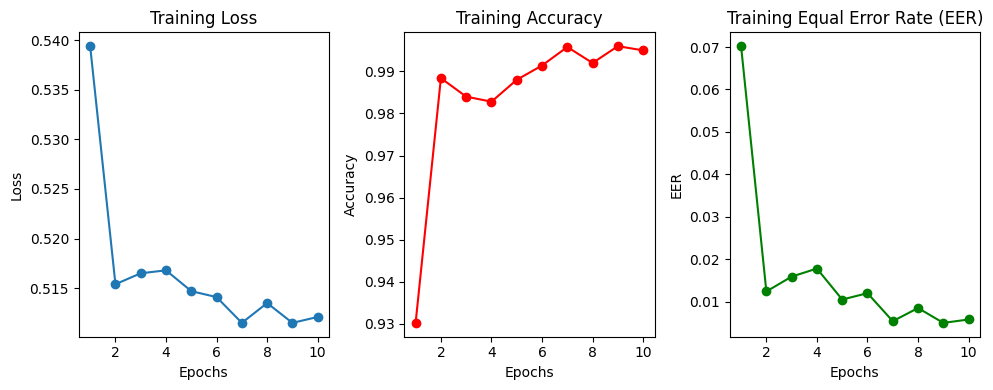

In [26]:
import matplotlib.pyplot as plt

epochs = range(1, 11)  # Assuming 10 epochs in this case

train_loss = [0.5394, 0.5154, 0.5165, 0.5168, 0.5147, 0.5141, 0.5115, 0.5135, 0.5115, 0.5121]
train_accuracy = [0.9302, 0.9884, 0.9840, 0.9828, 0.9880, 0.9914, 0.9958, 0.9920, 0.9960, 0.9950]
train_eer = [0.0702, 0.0124, 0.0159, 0.0178, 0.0105, 0.0120, 0.0054, 0.0085, 0.0050, 0.0058]

plt.figure(figsize=(10, 4))

# Plot Training Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss, marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plot Training Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracy, marker='o', color='r')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot Training EER
plt.subplot(1, 3, 3)
plt.plot(epochs, train_eer, marker='o', color='g')
plt.title('Training Equal Error Rate (EER)')
plt.xlabel('Epochs')
plt.ylabel('EER')

plt.tight_layout()
plt.show()


In [29]:
# Load the saved model
model = CRNN_Model(num_class=2, msr_size=(23, 8), rnn_hidden_size=128, dropout=0.7, tem_fac=[1, 2, 1])
model.load_state_dict(torch.load("crnn_model_epoch_10.pt"))  # Replace X with the desired epoch number
model.to(device)
model.eval() 

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [49]:
# Load the saved model on CPU
model = CRNN_Model(num_class=2, msr_size=(23, 8), rnn_hidden_size=128, dropout=0.7, tem_fac=[1, 2, 1])
model.load_state_dict(torch.load("crnn_model_epoch_10.pt", map_location=torch.device('cpu')))  # Replace X with the desired epoch number
model.eval()  # Set the model to evaluation mode

CRNN_Model(
  (dp): Dropout(p=0.7, inplace=False)
  (relu): ReLU(inplace=True)
  (sig): Sigmoid()
  (tanh): Tanh()
  (cnn1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
  )
  (cnn2): Sequential(
    (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(2, 1, 1), stride=(2, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
  )
  (cnn3): Sequential(
    (0): Conv3d(16, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 1, 1

In [50]:
# TEST

test_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt',
                       sep=" ", header=None)
test_df.columns =['speaker_id','filename','system_id','null','class_name']
test_df.drop(columns=['null'],inplace=True)
test_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_dev/flac/'+test_df.filename+'.flac'
test_df['target'] = (test_df.class_name=='spoof').astype('int32')
len(test_df)

24844

In [51]:
test_dataset = SRMRDataset(test_df[:5000])
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [52]:
# Prepare and process test data

# Make predictions
y_true = []
y_scores = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # Store true labels and predicted scores for EER calculation
        y_true.extend(target.cpu().numpy())
        y_scores.extend(output.cpu().detach().numpy())

# Calculate EER
eer = calculate_eer(np.array(y_true), np.array(y_scores))
print(f"Test EER: {eer:.4f}")

RuntimeError: expected scalar type Double but found Float

In [55]:
total_correct = 0
total_samples = 0

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        output = model(data)
    predicted_labels = (output > 0.5).float()  # Assuming 0.5 threshold for binary classification
    total_correct += (predicted_labels == target).sum().item()
    total_samples += target.size(0)

test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

RuntimeError: expected scalar type Double but found Float